In [1]:
import os
import numpy as np
import pandas as pd

import rocks
rocks.set_log_level("error")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import figure_setup as fs


In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [4]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']


In [5]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [6]:
bft = pd.read_parquet(bft_file)

cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )


In [7]:
len(data)

115147

# Compare results

In [8]:
data.HG1G2_status.value_counts()

 2.0    106453
 4.0      6708
 1.0      1248
 3.0       497
-2.0       238
 0.0         3
Name: HG1G2_status, dtype: int64

In [9]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_sHG1G2_g = (data.sHG1G2_G1_g>thres)  & (data.sHG1G2_G2_g>thres) & ((1-data.sHG1G2_G1_g-data.sHG1G2_G2_g)>thres)
mask_sHG1G2_r = (data.sHG1G2_G1_r>thres)  & (data.sHG1G2_G2_r>thres) & ((1-data.sHG1G2_G1_r-data.sHG1G2_G2_r)>thres)
mask_sHG1G2_ZTF = mask_sHG1G2_g & mask_sHG1G2_r
mask_sHG1G2_fit = (data.sHG1G2_fit==0)  & (data.sHG1G2_status>=2)
mask_sHG1G2 = mask_sHG1G2_fit & mask_sHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.sHG1G2_alpha0>thres) & ( np.abs(360-data.sHG1G2_alpha0)>thres )  & \
           ( np.abs(data.sHG1G2_alpha0-180)>thres) & ( np.abs(data.sHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.minphase<2.5

# Global mask
mask = mask_HG1G2 & mask_sHG1G2


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_sHG1G2_g]):6d}  ({100.*len(data[mask_sHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_sHG1G2_r]):6d}  ({100.*len(data[mask_sHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_sHG1G2]):6d}  ({100.*len(data[mask_sHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')

 All data       : 115147  (100.00%)

  Mask HG g      : 114904  ( 99.79%)
  Mask HG r      : 114906  ( 99.79%)
  Mask HG g+r    : 112564  ( 97.76%)

  Mask HG1G2 g   :  56815  ( 49.34%)
  Mask HG1G2 r   :  62043  ( 53.88%)
  Mask HG1G2 g+r :  40727  ( 35.37%)

  Mask SHG1G2 g  :  70736  ( 61.43%)
  Mask SHG1G2 r  :  75544  ( 65.61%)
  Mask SHG1G2 g+r:  55579  ( 48.27%)

  Mask Spin      : 111357  ( 96.71%)

  Mask (both)    :  34691  ( 30.13%)
  Mask phase 2  :  57515  ( 49.95%)
  Mask phase 3  :  79455  ( 69.00%)
  Mask phase 4  :  93564  ( 81.26%)
  Mask phase 5  : 101933  ( 88.52%)


## Figure RMS

In [15]:
fig, ax = plt.subplots(
    2,
    3,
    figsize=fs.figsize(0.5),
    gridspec_kw={
        "hspace": 0.02,
        "wspace": 0.02,
        "top": 0.98,
        "bottom": 0.065,
        "left": 0.095,
        "right": 0.98,
    },
)

r = [0, 0.5]
b = 50
vmin = 0.99
vmax = 1000

# --------------------------------------------------------------------------------
x = data.loc[mask_HG1G2, "HG_rms_g"]
y = data.loc[mask_HG1G2, "HG1G2_rms_g"]
_, _, _, im_g = ax[0, 0].hist2d(
    x, y, range=[r, r], bins=b, norm="log", cmap="Blues", rasterized=True,
    vmin=vmin, vmax=vmax
)

axinsg = inset_axes(
    ax[0, 0],
    width="50%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper center",
)
cbar_g = fig.colorbar(im_g, cax=axinsg, orientation="horizontal")
cbar_g.ax.set_xticks([1, 1000])
cbar_g.ax.set_xticklabels(["1", "1000"], fontsize="small")

ax[0, 0].set_ylabel("RMS in g")
ax[0, 0].text(0.95, 0.05, "HG", ha="right", transform=ax[0, 0].transAxes)
ax[0, 0].text(
    0.1,
    0.95,
    "HG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[0, 0].transAxes,
)


x = data.loc[mask_HG1G2, "HG_rms_r"]
y = data.loc[mask_HG1G2, "HG1G2_rms_r"]
_, _, _, im_r = ax[1, 0].hist2d(
    x, y, range=[r, r], bins=b, norm="log", cmap="Oranges", rasterized=True,
    vmin=vmin, vmax=vmax
)


axinsr = inset_axes(
    ax[1, 0],
    width="50%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper center",
)
cbar_r = fig.colorbar(im_r, cax=axinsr, orientation="horizontal")
cbar_r.ax.set_xticks([1, 1000])
cbar_r.ax.set_xticklabels(["1", "1000"], fontsize="small")

ax[1, 0].set_ylabel("RMS in r")
ax[1, 0].text(0.95, 0.05, "HG", ha="right", transform=ax[1, 0].transAxes)
ax[1, 0].text(
    0.1,
    0.95,
    "HG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[1, 0].transAxes,
)

# --------------------------------------------------------------------------------
x = data.loc[mask_sHG1G2, "HG_rms_g"]
y = data.loc[mask_sHG1G2, "sHG1G2_rms_g"]
ax[0, 1].hist2d(x, y, range=[r, r], bins=b, norm="log", cmap="Blues", rasterized=True,
    vmin=vmin, vmax=vmax)
ax[0, 1].text(0.95, 0.05, "HG", ha="right", transform=ax[0, 1].transAxes)
ax[0, 1].text(
    0.1,
    0.95,
    "sHG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[0, 1].transAxes,
)

x = data.loc[mask_sHG1G2, "HG_rms_r"]
y = data.loc[mask_sHG1G2, "sHG1G2_rms_r"]
ax[1, 1].hist2d(x, y, range=[r, r], bins=b, norm="log", cmap="Oranges", rasterized=True,
    vmin=vmin, vmax=vmax)
ax[1, 1].text(0.95, 0.05, "HG", ha="right", transform=ax[1, 1].transAxes)
ax[1, 1].text(
    0.1,
    0.95,
    "sHG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[1, 1].transAxes,
)

# --------------------------------------------------------------------------------
mm = mask_HG1G2 & mask_sHG1G2
x = data.loc[mm, "HG1G2_rms_g"]
y = data.loc[mm, "sHG1G2_rms_g"]
ax[0, 2].hist2d(x, y, range=[r, r], bins=b, norm="log", cmap="Blues", rasterized=True,
    vmin=vmin, vmax=vmax)
ax[0, 2].text(0.95, 0.05, "HG$_1$G$_2$", ha="right", transform=ax[0, 2].transAxes)
ax[0, 2].text(
    0.1,
    0.95,
    "sHG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[0, 2].transAxes,
)

x = data.loc[mm, "HG1G2_rms_r"]
y = data.loc[mm, "sHG1G2_rms_r"]
ax[1, 2].hist2d(x, y, range=[r, r], bins=b, norm="log", cmap="Oranges", rasterized=True,
    vmin=vmin, vmax=vmax)
ax[1, 2].text(0.95, 0.05, "HG$_1$G$_2$", ha="right", transform=ax[1, 2].transAxes)
ax[1, 2].text(
    0.1,
    0.95,
    "sHG$_1$G$_2$",
    va="top",
    ha="center",
    rotation=90,
    transform=ax[1, 2].transAxes,
)

# --------------------------------------------------------------------------------
for a in ax[:, 1:].ravel():
    a.set_yticklabels("")
for a in ax[0, :].ravel():
    a.set_xticklabels("")
for a in ax.ravel():
    a.set_aspect('equal')

# --------------------------------------------------------------------------------
fig.savefig(
    os.path.join(data_fink, "gfx", "models", "rms_comparison_masked.png"),
    facecolor="white",
)

fig.savefig(
    os.path.join(data_fink, "gfx", "article", "rms_comparison_masked.pgf"),
)
plt.close()

Text(0.1, 0.8, 'HG1G2 - sHG1G2')

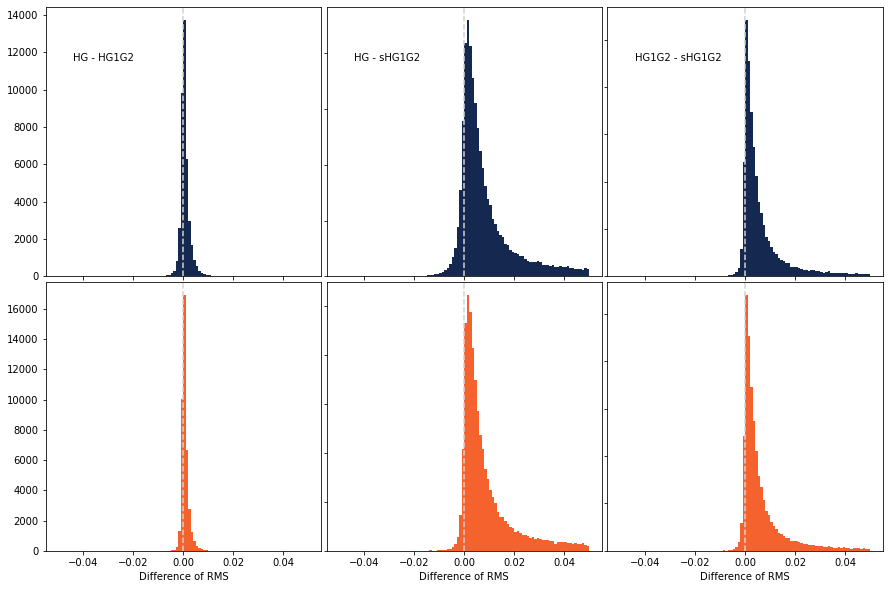

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-0.05,0.05]
b = 100

x = data.loc[mask_HG1G2,'HG_rms_g']
y = data.loc[mask_HG1G2,'HG1G2_rms_g']
ax[0,0].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_HG1G2,'HG_rms_r']
y = data.loc[mask_HG1G2,'HG1G2_rms_r']
ax[1,0].hist( x-y, range=r, bins=b, color=fink_colors[1])


x = data.loc[mask_sHG1G2,'HG_rms_g']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_g']
ax[0,1].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_sHG1G2,'HG_rms_r']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_r']
ax[1,1].hist( x-y, range=r, bins=b, color=fink_colors[1])


mm = mask_HG1G2 & mask_sHG1G2
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'sHG1G2_rms_g']

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'sHG1G2_rms_r']
ax[0,2].hist( x-y, range=r, bins=b, color=fink_colors[0])
ax[1,2].hist( x-y, range=r, bins=b, color=fink_colors[1])


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
for a in ax[1,:].ravel():
    a.set_xlabel('Difference of RMS')

for a in ax.ravel():
    a.axvline(0, linestyle='dashed', color='lightgrey' )
    
# ax[0,0].text( -0.04, 1000, 'HG HG1G2', ha='left')
# ax[0,1].text( -0.04, 1000, 'HG sHG1G2', ha='left')
# ax[0,2].text( -0.04, 1000, 'HG1G2 sHG1G2', ha='left')

ax[0,0].text( 0.1, 0.8, 'HG - HG1G2', transform=ax[0,0].transAxes)
ax[0,1].text( 0.1, 0.8, 'HG - sHG1G2', transform=ax[0,1].transAxes)
ax[0,2].text( 0.1, 0.8, 'HG1G2 - sHG1G2', transform=ax[0,2].transAxes)



- use that to get best and worst improvement

In [42]:

cols = ['sso_number','sso_name', 
        'minphase', 'maxphase', 'n_days', 'n_obs',
        'HG_H_r', 'HG_G_r', 'HG_rms_r', 
        'HG1G2_H_r', 'HG1G2_G1_r', 'HG1G2_G2_r', 'HG1G2_rms_r', 
        'sHG1G2_H_r', 'sHG1G2_G1_r', 'sHG1G2_G2_r', 'sHG1G2_rms_r']

improved = data.loc[mask_HG1G2 & mask_sHG1G2, cols]

improved_from_HG = improved.loc[(improved.HG_rms_r - improved.HG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)
improved_from_HG1G2 = improved.loc[(improved.HG1G2_rms_r - improved.sHG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)


# Spins

In [43]:
data.columns

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       ...
       'spins.3.DEC0.value', 'spins.3.long.value', 'spins.3.lat.value',
       'spins.3.technique', 'spins.4.obliquity', 'spins.4.RA0.value',
       'spins.4.DEC0.value', 'spins.4.long.value', 'spins.4.lat.value',
       'spins.4.technique'],
      dtype='object', length=151)

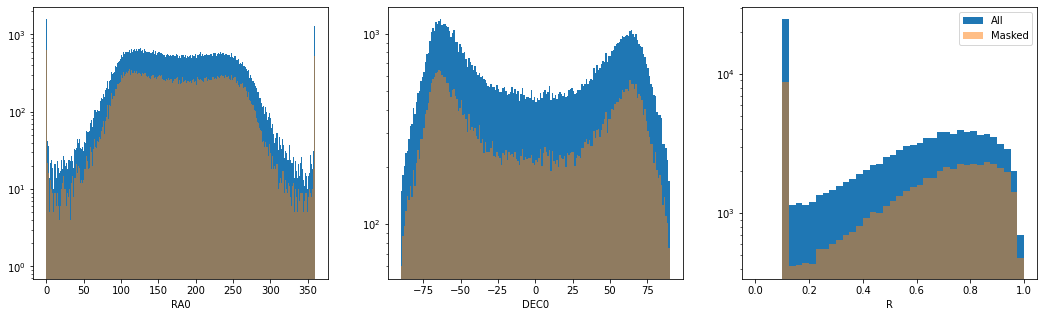

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0,360]
b = 360
ax[0].hist( data.loc[:,'sHG1G2_alpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_sHG1G2,'sHG1G2_alpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [-90,90]
b = 180
ax[1].hist( data.loc[:,'sHG1G2_delta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_sHG1G2,'sHG1G2_delta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'sHG1G2_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_sHG1G2,'sHG1G2_R'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'RA0')
ax[1].set_xlabel(f'DEC0')
ax[2].set_xlabel(f'R')

for a in ax:
    a.set_yscale('log')
ax[2].legend(loc='upper right')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'spin_histo.png'), facecolor='white')

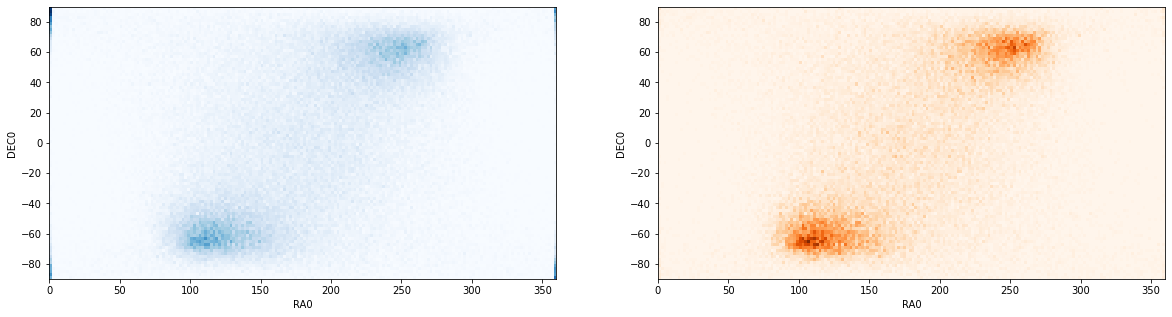

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# ax.scatter( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'] )
ax[0].hist2d( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data.loc[mask_sHG1G2&maskSpin,'sHG1G2_alpha0'], data.loc[mask_sHG1G2&maskSpin,'sHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'RA0')
    a.set_ylabel(f'DEC0')


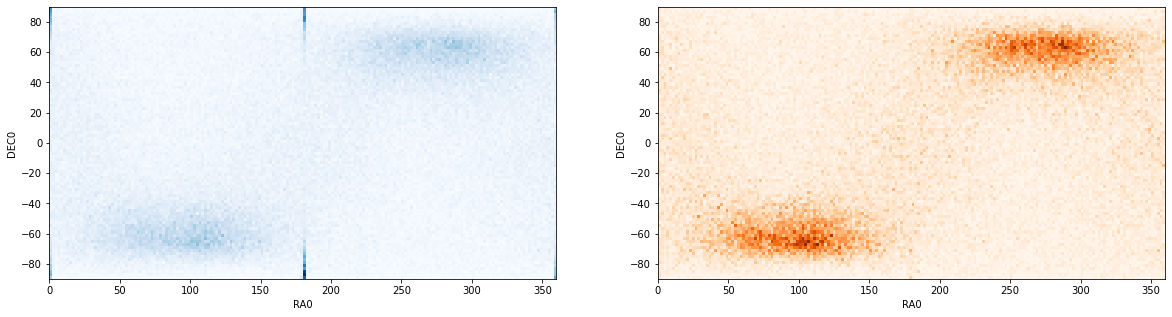

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# Flip half spins
data_flipped = data.copy()
cond = (data_flipped.index %2 ==0 )
xax = 'sHG1G2_alpha0'
yax = 'sHG1G2_delta0'

data_flipped.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data_flipped.loc[cond,yax] = -data.loc[cond,yax]

# ax.scatter( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'] )
ax[0].hist2d( data_flipped.loc[:,'sHG1G2_alpha0'], data_flipped.loc[:,'sHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data_flipped.loc[mask_sHG1G2&maskSpin,'sHG1G2_alpha0'], data_flipped.loc[mask_sHG1G2&maskSpin,'sHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'RA0')
    a.set_ylabel(f'DEC0')


# Uncertainties on parameters

In [48]:
data.columns[:90]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'sHG1G2_max_phase_1',
       'sHG1G2_kurtosis_delta_RA_cos_DEC', 'sHG1G2_max_phase_2',
       'sHG1G2_max_cos_lambda', 'sHG1G2_fit', 'sHG1G2_R',
       'sHG1G2_min_cos_lambda', 'sHG1G2_kurtosis_delta_DEC', 'sHG1G2_n_obs',
       'sHG1G2_skew_delta_DEC', 'sHG1G2_err_G2_1', 'sHG1G2_err_G1_2',
       'sHG1G2_skew_delta_RA_cos_DEC', 'sHG1G2_n_days', 'sHG1G2_err_G1_1',
       'sHG1G2_rms', 'sHG1G2_err_G2_2', 'sHG1G2_G2_g',

Text(0.5, 0, 'dR')

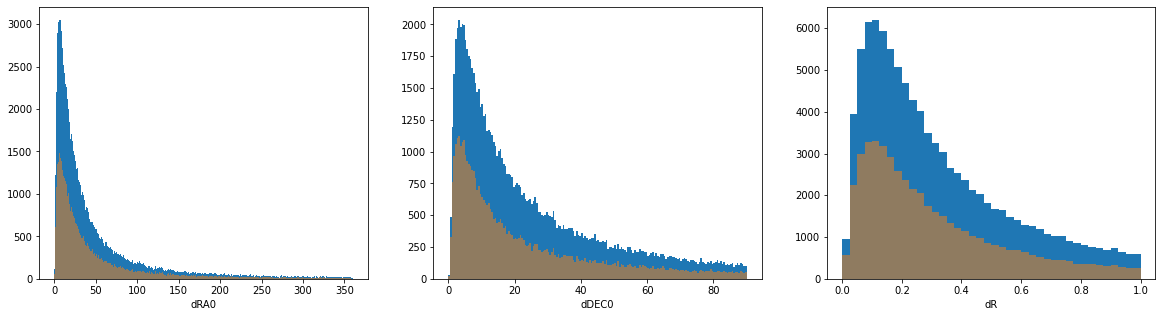

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


r = [0,360]
b = 360
ax[0].hist( data.loc[:,'sHG1G2_err_alpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_sHG1G2,'sHG1G2_err_alpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,90]
b = 180
ax[1].hist( data.loc[:,'sHG1G2_err_delta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_sHG1G2,'sHG1G2_err_delta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'sHG1G2_err_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_sHG1G2,'sHG1G2_err_R'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'dRA0')
ax[1].set_xlabel(f'dDEC0')
ax[2].set_xlabel(f'dR')